# Fit a simple kinematic model for the Milky Way disk to the OBA star proper motion data

This notebook is based on the analysis of the B-star proper motions from section 10.1 in the paper _Gaia Data Release 3: A Golden Sample of Astrophysical Parameters_ by [Gaia Collaboration, Creevey et al (2022)]().

__NOTE: This notebook is not intended to reproduce the results from the paper. It uses NumPyro instead of Stan (which in principle does not matter) and contains several other changes. For the notebook that reproduces the results see [this repository](https://github.com/agabrown/milkyway-disk-proper-motions).__

A simple Milky Way disk circular velocity curve is fit to the proper motion data, with the following parameters:
* $v_\mathrm{circ,\odot}$ the circular velocity at the location of sun (positive by convention, in km/s)
* Rotation curve $f_{\boldsymbol{\theta}}(R)$, with parameters $\boldsymbol{\theta}$, which provides the rotation velocity at $R$ in km/s
* $\mathbf{v}_{\odot,\mathrm{pec}}$ the peculiar motion vector of the sun (km/s)
* Velocity dispersions with respect to pure circular motion (assumed constant across the disk) in the three Galactocentric cylindrical coordinate directions:
  * $\sigma_{R}$ the velocity dispersion around the $\hat{\mathbf{R}}$ direction (1D normal, km/s)
  * $\sigma_\phi$ the velocity dispersion around the $\hat{\boldsymbol{\phi}}$ direction (1D normal, km/s)
  * $\sigma_z$ the velocity dispersion around the $\hat{\mathbf{z}}$ direction (1D normal, km/s)

Fixed parameters:
* $R_\odot$ distance from the sun to the galactic centre, assumed known from GRAVITY measurements. The value used is $8.277$ kpc from [GRAVITY Collaboration et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657L..12G).
* $y_\odot$ The Galactic Cartesian $y$-coordinate of the Sun, by definition 0 kpc.
* $z_\odot$ the height of the sun above (or below) the galactic plane (pc). The value $20.8\times10^{-3}$ kpc from [Bennett & Bovy (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B/abstract) is often used. Here the default is 0 kpc. NOTE that one can introduce $z_\odot$ as a parameter in the model below, but experiments showed that the data has no constraining power on $z_\odot$ (even if mathematically the proper motions also depend on $z_\odot$), as the posterior distribution on the sun's height is the same as the prior.
* $\varpi_i$ parallaxes of the stars are assumed known for now (high precision subsample is used). The parallax uncertainties are thus ignored. Units of mas.
* Source coordinates $(\ell,b)_i$, assumed error free

Observations:
* Proper motions $(\mu_{\ell\star}, \mu_b)$ in $\ell$ and $b$ (mas/yr) with corresponding covariance matrices $\mathsf{C}_{\boldsymbol{\mu}}$.

## Probabilistic graphical model

<img src="./img/rotcurve-pgm.png" width=800px/>

The graph shows the probabilistic model for the observed proper motions $\boldsymbol{\mu}_i$. The full set of model parameters to be inferred is:
\begin{equation}
    \left\{ v_{\mathrm{circ},\odot}, \mathbf{v}_{\mathrm{pec},\odot}, \sigma_R, \sigma_\phi, \sigma_z, \boldsymbol{\theta} \right\}\,.
\end{equation}
The parameters $\mathbf{v}_\odot$, $\mathbf{v}_i$, and $\mathsf{S}_i$ are latent variables in this model.

## Model details

The stars are assumed to follow strictly circular orbits where the orbital velocity is independent of the galactocentric $z$ coordinate. The velocity $\mathbf{v}$ of a star with parallax $\varpi$ is calculated according to the following steps:

For a star at coordinates $(\ell, b)$ calculate the normal triad $[\mathbf{p}, \mathbf{q}, \mathbf{r}]$:

\begin{equation}
    \mathbf{p} = \begin{pmatrix} -\sin\ell \\ \cos\ell \\ 0 \end{pmatrix}\,,\quad
    \mathbf{q} = \begin{pmatrix} -\sin b\cos\ell \\ -\sin b\sin\ell \\ \cos b \end{pmatrix}\,,\quad
    \mathbf{r} = \begin{pmatrix} \cos b\cos\ell \\ \cos b\sin\ell \\ \sin b \end{pmatrix}\,.
\end{equation}

Then calculate the Galactocentric Cartesian star position as:

\begin{equation}
    \mathbf{x} = (1/\varpi)\mathbf{r} + \mathbf{x}_\odot\,,
\end{equation}

with $\mathbf{x}$ the $(x,y,z)$ position of the star in kpc. The coordinate system is right-handed with the Sun located at $(-R_\odot, 0, z_\odot)$ and the sense of the Milky Way rotation such that the azimuthal velocity of the stars $v_\phi$ points in the negative $\hat{\boldsymbol{\phi}}$ direction (i.e. the rotation is clockwise as seen down the positive $z$-axis). The velocity of the star is calculated from the azimuthal velocity $v_\phi(R)$ as:

\begin{equation}
    \mathbf{v} = \begin{pmatrix} -v_\phi(R)\sin\phi \\ v_\phi(R)\cos\phi \\ 0 \end{pmatrix} \quad\text{with}\quad \phi=\text{atan2}(y, x) \quad\text{and}\quad
    R=\sqrt{x^2+y^2}\,.
\end{equation}

The azimuthal velocity $v_\phi(R)$ at the position of the star is calculated as:

\begin{equation}
    v_\phi(R) = -f_\boldsymbol{\theta}(R)\,,
\end{equation}
where the rotation curve depends on the parameters $\boldsymbol{\theta}$ and by convention returns a positive velocity.

Finally the proper motions are calculated as:

\begin{equation}
    \mu_{\ell*} = \frac{\varpi}{A_\mathrm{v}}\mathbf{p}\cdot(\mathbf{v}-\mathbf{v}_\odot)\,,\quad
    \mu_b = \frac{\varpi}{A_\mathrm{v}}\mathbf{q}\cdot(\mathbf{v}-\mathbf{v}_\odot)\,,
\end{equation}

The modelling is done in a Bayesian manner with likelihood:

\begin{equation}
    \mathbf{\mu}_\mathrm{obs} \sim {\cal N}\left(\mathbf{\mu}_\mathrm{model}, \mathsf{D}_\mathrm{\mu} \right)\,,
\end{equation}

where the covariance matrix in the likelihood is given as:

\begin{equation}
    \mathsf{D}_\mu = \mathsf{C}_\mu + \begin{pmatrix} \mathbf{p}'\mathsf{S}\mathbf{p} & \mathbf{p}'\mathsf{S}\mathbf{q} \\
    \mathbf{q}'\mathsf{S}\mathbf{p} & \mathbf{q}'\mathsf{S}\mathbf{q}
    \end{pmatrix} (\varpi/A_\mathrm{v})^2\,,
\end{equation}

with the matrix $\mathsf{S}$ representing the velocity dispersion in Cartesian coordinates, but with model parameters in cylindrical coordinates:

\begin{equation}
    \mathsf{S} =  \mathsf{J}
    \begin{pmatrix}
        \sigma^2_{R} & 0 & 0 \\
        0 & \sigma_{\phi}^2 & 0 \\
        0 & 0 & \sigma_z^2
    \end{pmatrix} \mathsf{J}' \quad\text{where}\quad
    \mathsf{J} = \begin{pmatrix}
        \cos\phi & -\sin\phi & 0 \\
        \sin\phi & \cos\phi & 0 \\
        0 & 0 & 1
    \end{pmatrix}
\end{equation}

### Rotation curve models

Two rotation curve models are used. The first is a linear rotation curve:
\begin{equation}
    f_\boldsymbol{\theta}(R) = v_\mathrm{circ,\odot} + \frac{dv_\mathrm{circ}}{dR}(R-R_\odot) \quad\text{with}\quad
    \boldsymbol{\theta} = \left\{\frac{dv_\mathrm{circ}}{dR}\right\}\,.
\end{equation}
The second is the rotation curve presented in equation (7) of [Brunetti & Pfenniger (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...510A..34B/abstract):
\begin{equation}
    f_\boldsymbol{\theta}(R) = \left(v_0\frac{R}{h}\left[1+\left(\frac{R}{h}\right)^2\right]^{\frac{p-2}{4}}\right) \quad\text{with}\quad
    v_0 = v_{\mathrm{circ},\odot}\left(\frac{R_\odot}{h}\left[1+\left(\frac{R_\odot}{h}\right)^2\right]^{\frac{p-2}{4}}\right)^{-1} \quad\text{and}\quad
    \boldsymbol{\theta} = \left\{p, h\right\}\,.
\end{equation}

The priors on the circular velocity at the sun, the slope of the circular velocity curve, and the sun's peculiar motion components are all normal distributions. The priors on the components of $\mathsf{S}$ are uniform distributions.

## Imports and constants

In [1]:
import numpy as np
#from jax import numpy as jnp, random, local_device_count
from jax import random
import numpyro
from numpyro import sample, handlers
from numpyro.distributions import (
    ImproperUniform,
    Normal,
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import Predictive
from numpyro.diagnostics import summary, print_summary

import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import scoreatpercentile as scap

import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

numpyro.set_host_device_count(4)

from numpyromodels import linear_vcirc_disptens_rphiz
useagab()

## Read in the data

First query the Gaia DR3 archive for the data necessary to reproduce the analysis and store in the `../data` folder.

```sql
select gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error,
gaia.pmdec, gaia.pmdec_error, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, 
gaia.radial_velocity, gaia.radial_velocity_error, gaia.rv_template_teff, gaia.grvs_mag, 
gaia.phot_g_mean_mag, gaia.bp_rp, gaia.g_rp, gaia.bp_g, 
gaia.ag_gspphot, gaia.ebpminrp_gspphot, gaia.teff_gspphot, gaia.logg_gspphot,
aps.teff_esphs, aps.logg_esphs, aps.ag_esphs, aps.ebpminrp_esphs, aps.spectraltype_esphs, oba.vtan_flag
from gaiadr3.gold_sample_oba_stars as oba
join gaiadr3.astrophysical_parameters as aps
using (source_id)
join gaiadr3.gaia_source as gaia
using (source_id)
```

The Cartesian and cylindrical galactocentric coordinates are calculate for the stars for use further down.

In [2]:
Rsun = 8.277*u.kpc
zsun = 0.0*u.kpc

obatable = load_mwtable('./data/OBAGoldenSample.fits', Rsun=Rsun, zsun=zsun)
obatable["parallax"] = np.float32(obatable["parallax"])

## Select a sub-sample to work with

Use a high precision parallax sample of B stars. Futher selections are done on the tangential velocity $v_\mathrm{tan}<v_\mathrm{tan,max}$, distance from the plane $|\sin(b)\times1000/\varpi|<z_\mathrm{max}$, and distance from Galactic centre $R_\mathrm{min}<R<R_\mathrm{max}$. The resulting selection is then subsampled randomly to create a manageable sample for the model fitting process.

Number of stars in selected sample: 427159


/home/brown/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brown/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


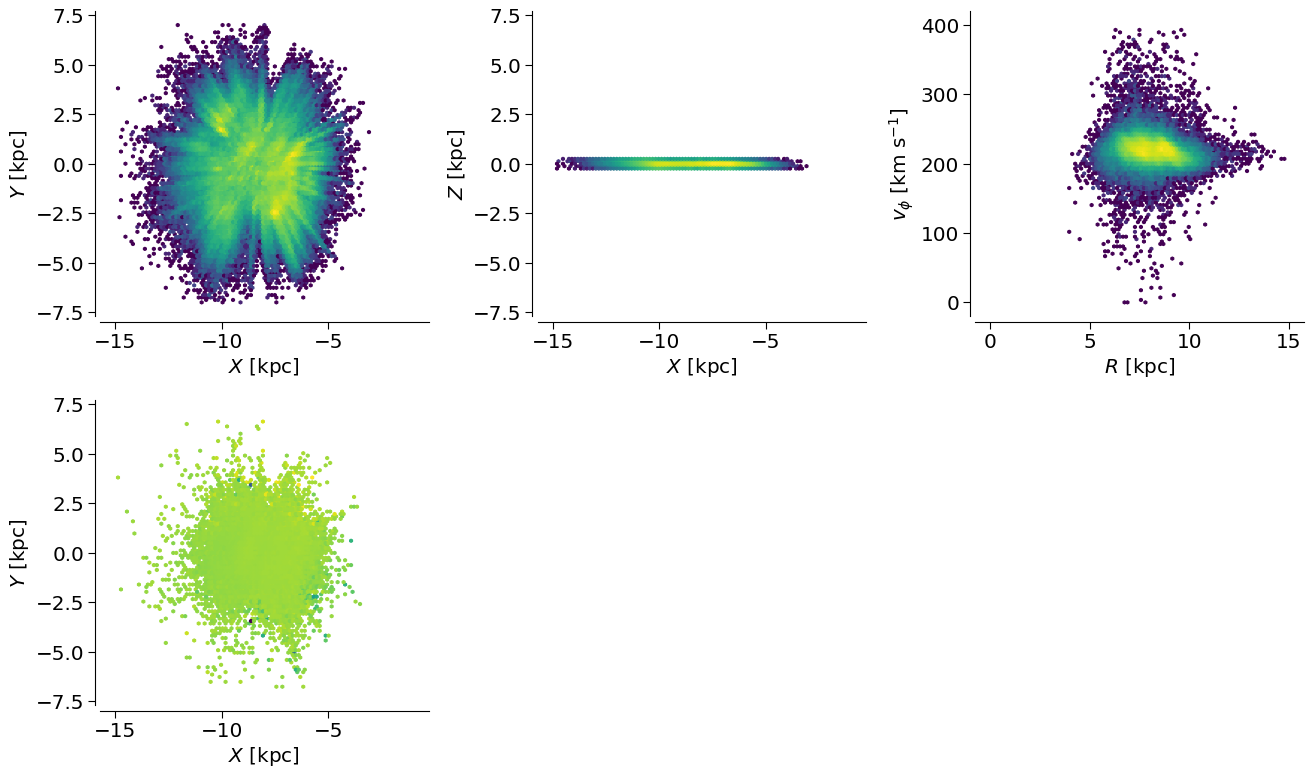

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

startype = (obatable['spectraltype_esphs'] == 'B')
plxfilter = obatable['parallax_over_error']>plx_snrlim
nonhalo = obatable['vtan'] < vtanhalo
zmax = 0.25

sample_filter_init = startype & plxfilter & nonhalo & (np.abs(np.sin(np.deg2rad(obatable['b']))*1.0/obatable['parallax']) < zmax)

R_filter = (obatable['R_gc']>6.5) & (obatable['R_gc']<15.0)

sample_filter = sample_filter_init #& R_filter

print(f"Number of stars in selected sample: {obatable['ra'][sample_filter].size}")

subsample_size = 3000
if (obatable['ra'][sample_filter].size <=subsample_size):
    oba_subsample = obatable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(obatable['ra'][sample_filter].size), size=subsample_size, replace=False)
    oba_subsample = obatable[sample_filter][random_subsample]
    
plotgrid = [-15, -1, -7, 7]
fig=plt.figure(figsize=(16.5,10), tight_layout=True)

gs = fig.add_gridspec(2, 3, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)
ax_rvphi = fig.add_subplot(gs[0,2])
apply_tufte(ax_rvphi)
ax_xy_vphi = fig.add_subplot(gs[1,0])
apply_tufte(ax_xy_vphi)

ax_xy.hexbin(obatable['x_gc'][sample_filter], obatable['y_gc'][sample_filter], mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(obatable['x_gc'][sample_filter], obatable['z_gc'][sample_filter], mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

hasrvs = sample_filter & obatable['rvvalid']
ax_rvphi.hexbin(obatable['R_gc'][hasrvs], obatable['v_phi_gc'][hasrvs], mincnt=1, bins='log', extent=[0,15,0,400])
ax_rvphi.set_xlabel(r'$R$ [kpc]') 
ax_rvphi.set_ylabel(r'$v_\phi$ [km s$^{-1}$]')

ax_xy_vphi.hexbin(obatable['x_gc'][hasrvs], obatable['y_gc'][hasrvs], mincnt=0, C=obatable['v_phi_gc'][hasrvs],
                  reduce_C_function=np.median, bins='log', extent=plotgrid)
ax_xy_vphi.set_xlabel(r'$X$ [kpc]') 
ax_xy_vphi.set_ylabel(r'$Y$ [kpc]') 

plt.show()

## Plot histogram of $\sin(b)\times 1000/\varpi$

Use this to estimate $z_\odot$ for this sample. Note that the precise value of $z_\odot$ has very little effect on the results.

Median d*sin(b): -20.8
RSE d*sin(b): 97.5
Mean d*sin(b): -17.9


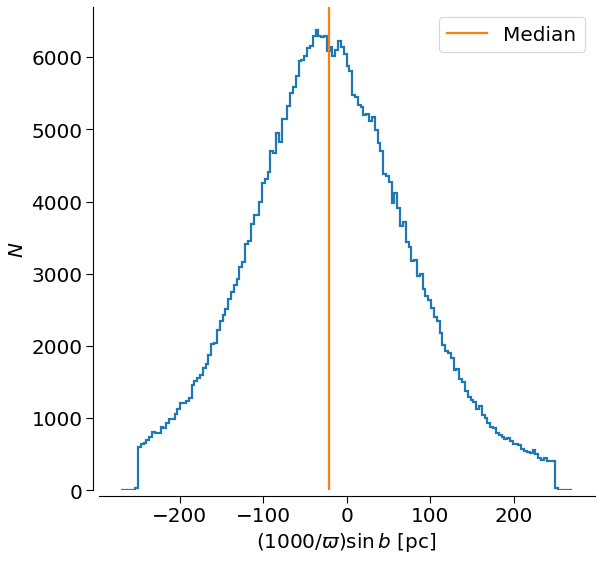

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(obatable['b'][sample_filter]))*1000.0/obatable['parallax'][sample_filter])
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
#-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-270,270])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

## Plot the sample proper motions as a function of galactic longitude

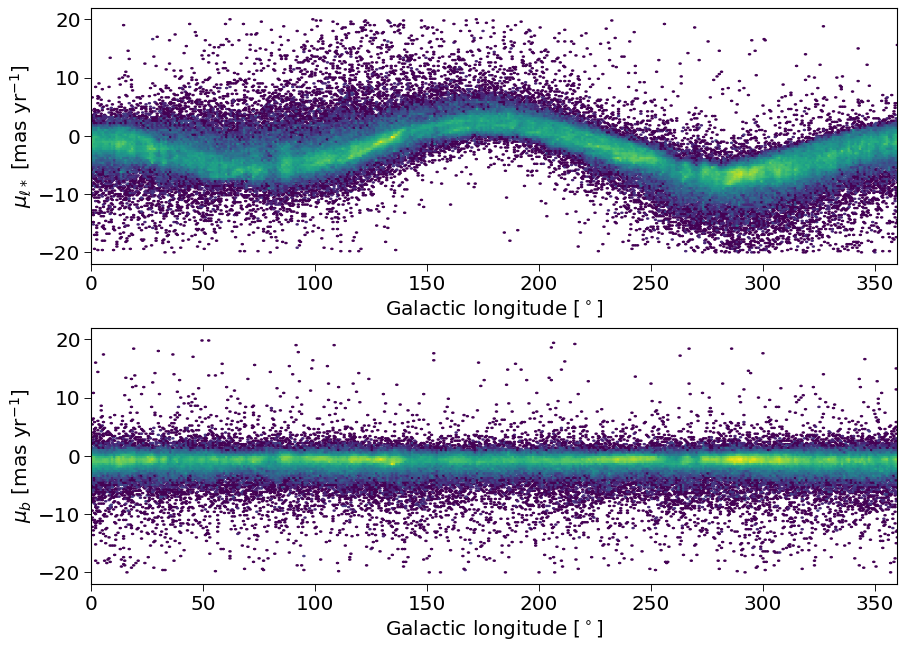

In [5]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('bstar-pml-pmb-vs-galon.png')

plt.show()

## Set up the NumPyro model

The rotation curve model implementation is located in a separate Python file and can be chosen below. The following inputs for the model are prepared:
* The observed proper motions in a (nsource, 2) array
* The covariance matrix describing the proper motion uncertainties (nsources, 2, 2) array
* The normal triad $[\mathbf{p}, \mathbf{q}, \mathbf{r}]$ at each source position (3000, 3) arrays

In [6]:
nsources = oba_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

pm_obs = np.stack([oba_subsample["pml"].value, oba_subsample["pmb"].value], axis=1)

cov_pm = np.stack(
    [
        oba_subsample["pml_error"].value ** 2,
        (oba_subsample["pml_error"] * oba_subsample["pmb_error"] * oba_subsample["pml_pmb_corr"]).value,
        (oba_subsample["pml_error"] * oba_subsample["pmb_error"] * oba_subsample["pml_pmb_corr"]).value,
        oba_subsample["pmb_error"].value ** 2,
    ]
).T.reshape(nsources, 2, 2)

p = np.stack(
    [-np.sin(np.deg2rad(oba_subsample["l"])), np.cos(np.deg2rad(oba_subsample["l"])), np.zeros(nsources)], axis=1
)
q = np.stack(
    [
        -np.sin(np.deg2rad(oba_subsample["b"])) * np.cos(np.deg2rad(oba_subsample["l"])),
        -np.sin(np.deg2rad(oba_subsample["b"])) * np.sin(np.deg2rad(oba_subsample["l"])),
        np.cos(np.deg2rad(oba_subsample["b"])),
    ],
    axis=1,
)
r = np.stack(
    [
        np.cos(np.deg2rad(oba_subsample["b"])) * np.cos(np.deg2rad(oba_subsample["l"])),
        np.cos(np.deg2rad(oba_subsample["b"])) * np.sin(np.deg2rad(oba_subsample["l"])),
        np.sin(np.deg2rad(oba_subsample["b"])),
    ],
    axis=1,
)

nuts_kernel = NUTS(linear_vcirc_disptens_rphiz)

Number of sources in sample: 3000


## Sample posterior

Feed the OBA star proper motion and parallax data to the NumPyro model and sample the posterior for the Milky Way parameters.

In [7]:
warmup = 500
sampling = 1000
sampler = MCMC(nuts_kernel, num_samples=sampling, num_warmup=warmup, num_chains=4, chain_method="parallel")
rng_key = random.PRNGKey(0)
sampler.run(rng_key, nsources, p, q, r, oba_subsample["parallax"], Rsun.value, zsun.value, cov_pm, pm_obs=pm_obs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

## Get posterior samples

In [8]:
posterior_samples = sampler.get_samples(group_by_chain=True)

## Summarize the fit results

In [9]:
fit_summary = summary(posterior_samples, group_by_chain=True)
print_summary(posterior_samples, group_by_chain=True)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   Vcirc_sun    232.88      1.46    232.86    230.50    235.23   6565.15      1.00
  Vsun_pec_x      8.04      0.38      8.04      7.42      8.68   6884.37      1.00
  Vsun_pec_y     13.88      0.38     13.88     13.26     14.50   6625.94      1.00
  Vsun_pec_z      8.39      0.13      8.39      8.18      8.60   7739.26      1.00
   dVcirc_dR     -1.90      0.21     -1.90     -2.25     -1.58   6233.76      1.00
    vdispPhi     13.00      0.34     12.99     12.45     13.57   6087.02      1.00
      vdispR     15.96      0.32     15.97     15.44     16.52   6245.65      1.00
      vdispZ      7.22      0.10      7.22      7.07      7.38   7869.98      1.00



## Plot the values of the MCMC chains vs iteration number

The burn-in samples have already been discarded.

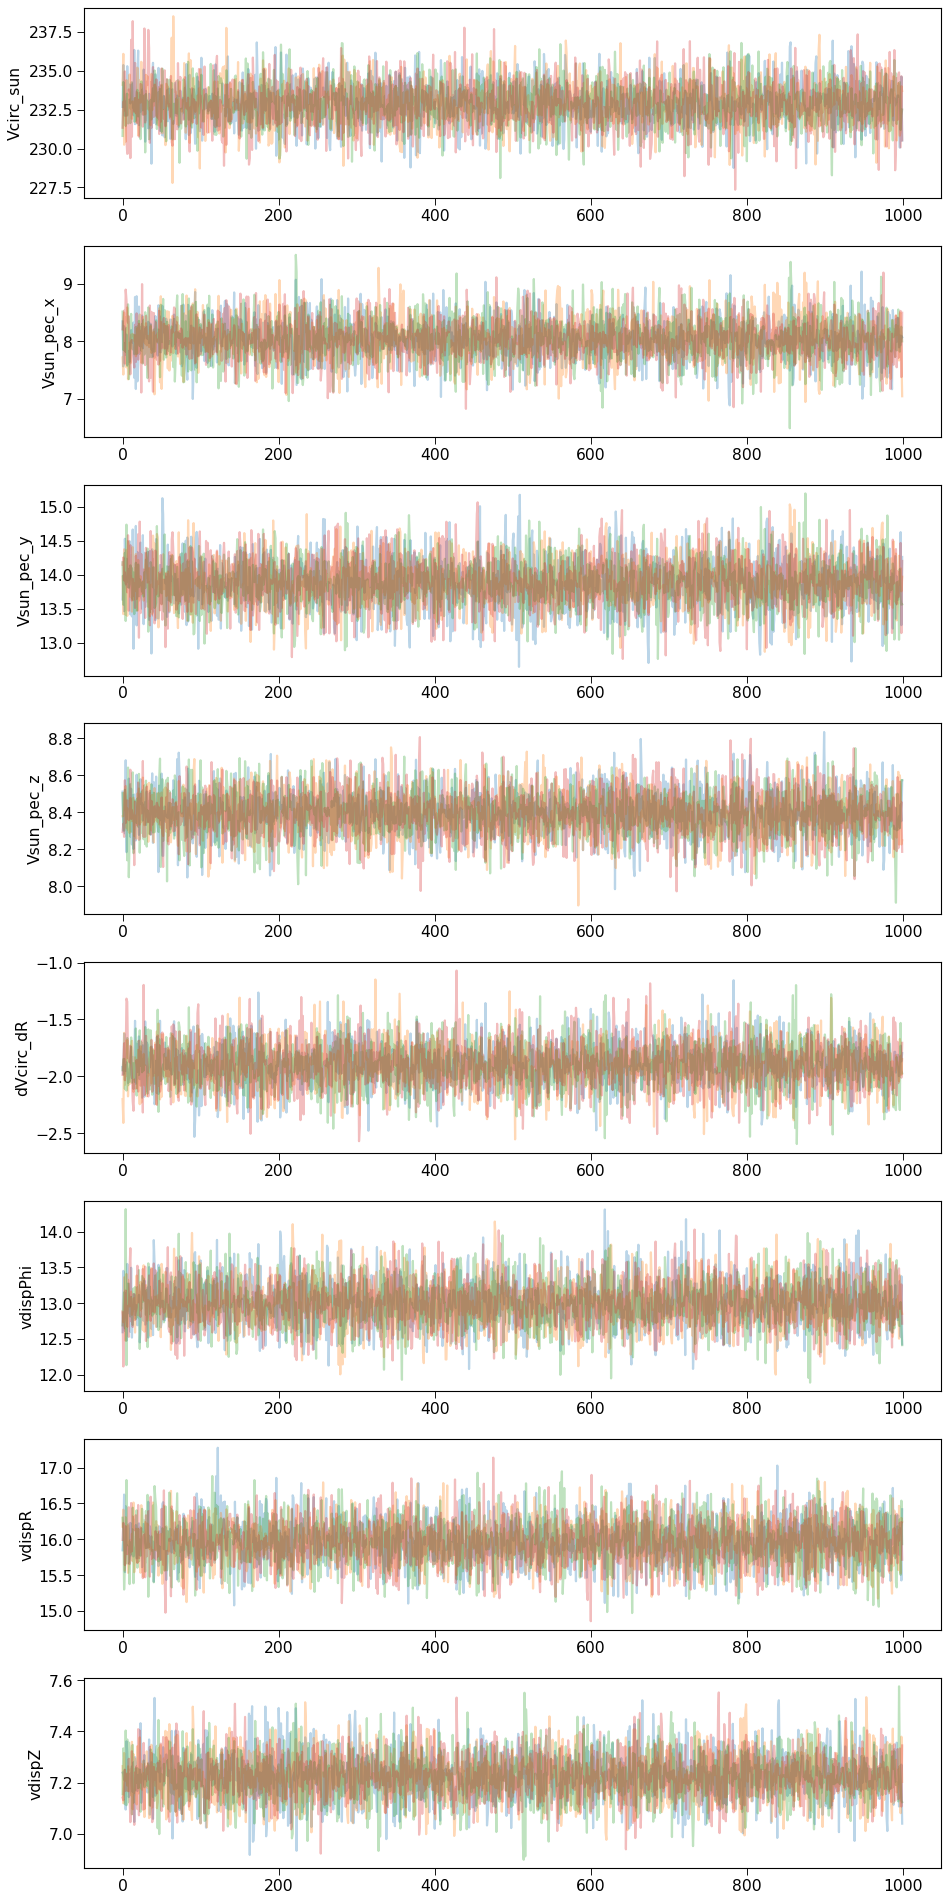

In [10]:
useagab(fontsize=14)

npars = len(posterior_samples.keys())
fig, axes = plt.subplots(ncols=1, nrows=npars, tight_layout=True, figsize=(12,3*npars))

for i, lab in zip(range(npars), posterior_samples.keys()):
    for k in range(posterior_samples[lab].shape[0]):
        axes[i].plot(posterior_samples[lab][k], alpha=0.3)
    axes[i].set_ylabel(lab)

plt.show()

## Make a corner plot of the posterior samples

__NOTE__ The model parameters are returned in alphabetical order (upper case first) by numpyro, so keep in mind when labeling the corner plot. Put parameter -> label mapping in model code.

Vcirc_sun = 232.9+1.5-1.4
Vsun_pec_x = 8.0+0.4-0.4
Vsun_pec_y = 13.9+0.4-0.4
Vsun_pec_z = 8.4+0.1-0.1
dVcirc_dR = -1.9+0.2-0.2
vdispPhi = 13.0+0.3-0.3
vdispR = 16.0+0.3-0.3
vdispZ = 7.2+0.1-0.1


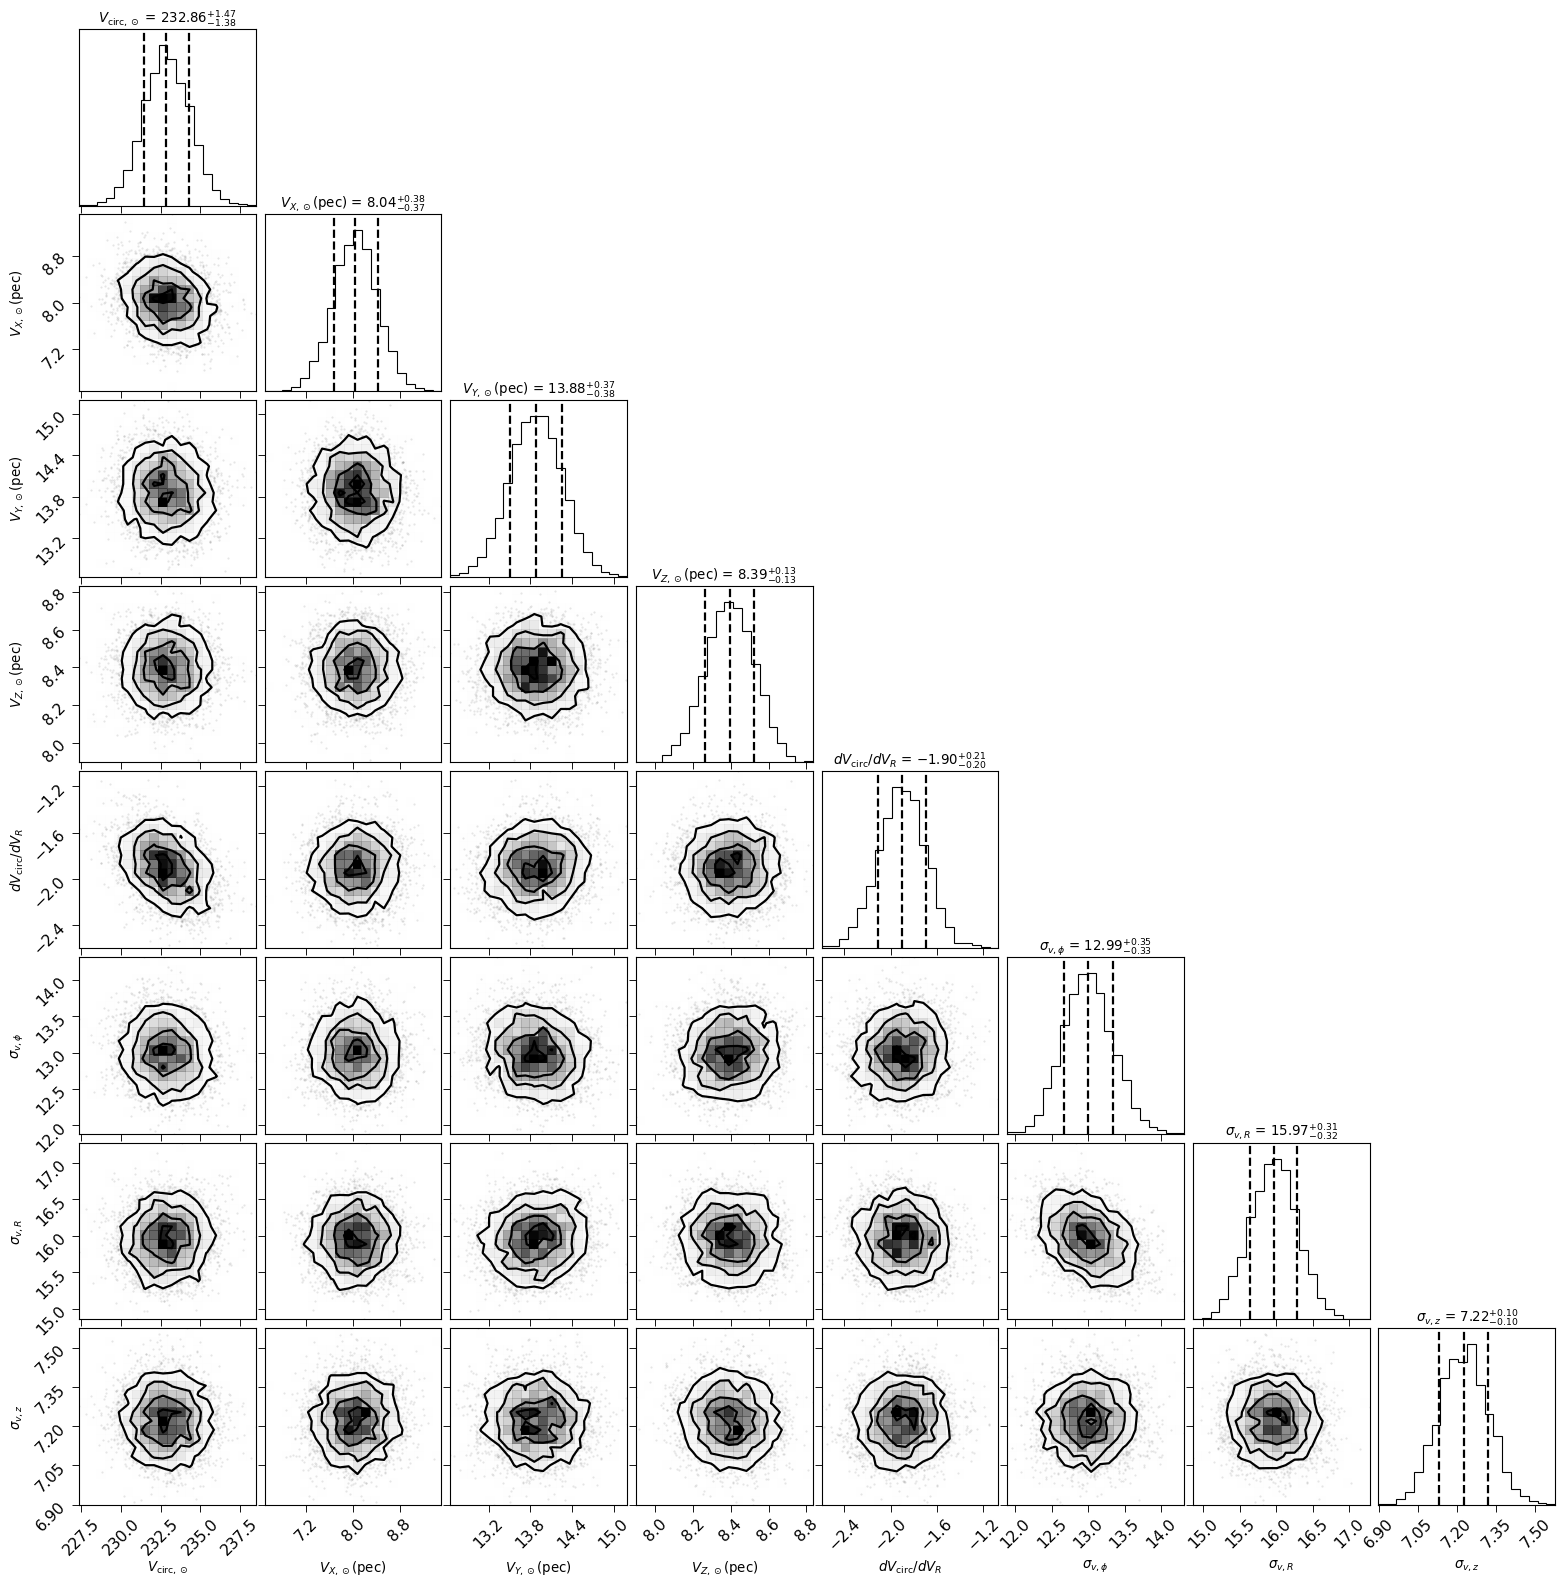

In [11]:
model_bestparams = {}
labels = [r'$V_{\mathrm{circ},\odot}$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
          r'$V_{Z,\odot}(\mathrm{pec})$', r'$dV_\mathrm{circ}/dV_R$', r'$\sigma_{v,\phi}$', r'$\sigma_{v,R}$', r'$\sigma_{v,z}$']
for par in posterior_samples.keys():
    vals = posterior_samples[par]
    model_bestparams[par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for par in posterior_samples.keys():
    sample_lists.append(posterior_samples[par].flatten())
samples = np.vstack(sample_lists).transpose()
                         
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*npars,2.5*npars))
corner.corner(
    samples, labels=labels, 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

## Model check through predictive posterior

In [12]:
posterior_predictive_samples = np.array(Predictive(linear_vcirc_disptens_rphiz, posterior_samples=sampler.get_samples())(
    random.PRNGKey(1), nsources, p, q, r, oba_subsample["parallax"], Rsun.value, zsun.value, cov_pm
)['obs'])

### Create an `InferenceData` instance by hand

Could not figure out how to create it from `az.from_numpyro`, probably due to 2D proper motion arrays(?).

In [13]:
pps = xr.Dataset(
    {
        "pml_pred": (["draw", "source_dim"], posterior_predictive_samples[:,:,0]),
        "pmb_pred": (["draw", "source_dim"], posterior_predictive_samples[:,:,1]),
    },
    coords={
        "chain": (["chain"], np.arange(1)),
        "draw": (["draw"], np.arange(posterior_predictive_samples.shape[0])),
        "source_dim": (["source_dim"], np.arange(posterior_predictive_samples.shape[1])),
    }
)
observed = xr.Dataset(
    {
        "pml_obs": (["source"], pm_obs[:,0]),
        "pmb_obs": (["source"], pm_obs[:,1]),
    },
    coords = {
        "source": (["source"], np.arange(pm_obs.shape[0])),
    }
)

idata = az.InferenceData(posterior_predictive=pps, observed_data=observed)

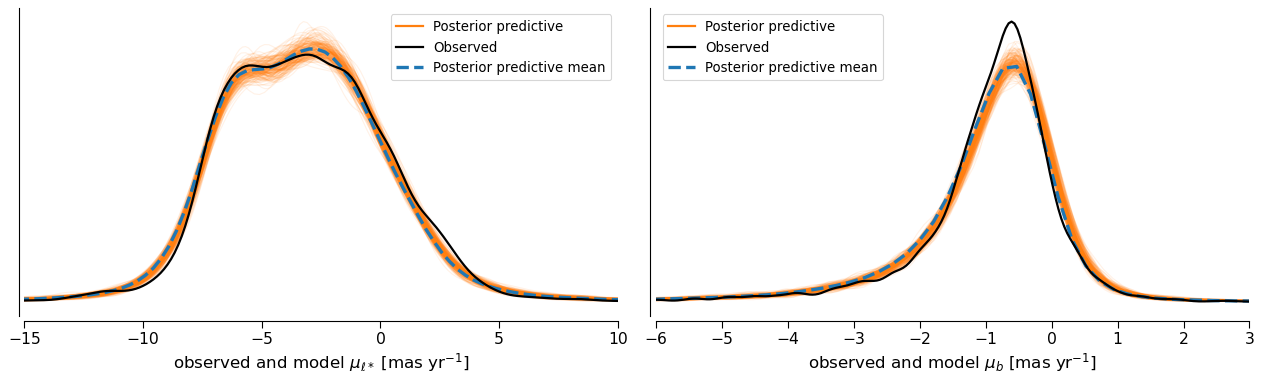

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(2*8, 5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pml_pred', 'pmb_obs':'pmb_pred'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    apply_tufte(ax)
axes[0].set_xlim(-15,10)
axes[1].set_xlim(-6,3)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('bstars_pms_posterior_predictive.png')

plt.show()

## Sgr A* proper motion (assuming no intrinsic motion for this source) and Oort constants

In [15]:
vsunx_samples = posterior_samples["Vsun_pec_x"].flatten()
vsuny_samples = posterior_samples["Vcirc_sun"].flatten()+posterior_samples["Vsun_pec_y"].flatten()
vsunz_samples = posterior_samples["Vsun_pec_z"].flatten()
vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

vsun_circ_samples = posterior_samples["Vcirc_sun"].flatten()
slope_samples = posterior_samples["dVcirc_dR"].flatten()

ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
dec_sgr = -29 - 28.118/2300
l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value
mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value
mu_sgr_xy = np.median(mu_sgr_xy_samples)
mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
mu_sgr_z = np.median(mu_sgr_z_samples)
mu_sgr_z_rse = rse(mu_sgr_z_samples)

print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

oortA_samples = (vsun_circ_samples/Rsun.value - slope_samples)/2
oortB_samples = (-vsun_circ_samples/Rsun.value - slope_samples)/2
oortAminB_samples = oortA_samples - oortB_samples
oortA = np.median(oortA_samples)
oortA_rse = rse(oortA_samples)
oortB = np.median(oortB_samples)
oortB_rse = rse(oortB_samples)
oortAminB = np.median(oortAminB_samples)
oortAminB_rse = rse(oortAminB_samples)

print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

-0.05951722261414716 -0.048464687832790516
mu_sgr_xy = -6.29  +/- 0.037
mu_sgr_z = -0.21  +/- 0.003
Oort A = 15.02  +/- 0.158
Oort B = -13.12  +/- 0.109
Oort A-B = 28.13  +/- 0.175


## Compare model predictions and observations in the proper motion vs longitude plots

Show both a model prediction for stars at a fixed distance from the sun and simulated proper motion data, using the simulated data ('generated quantities') from the STAN model.

In [16]:
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.kpc
vsunpeculiar = np.array([fit_summary['Vsun_pec_x']['median'], fit_summary['Vsun_pec_y']['median'], fit_summary['Vsun_pec_z']['median']])*u.km/u.s
vcircsun = fit_summary['Vcirc_sun']['median']
slope = fit_summary['dVcirc_dR']['median']

diskmodel = DiskKinematicModel(SlopedRotationCurve(vcircsun, Rsun.value, slope), sunpos, vsunpeculiar)

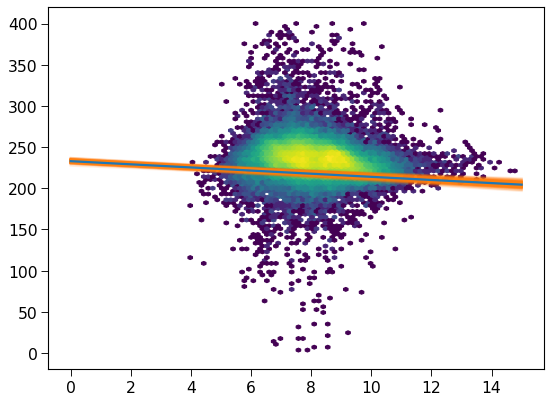

In [17]:
icrs_coords = ICRS(
    ra=(obatable['ra'][hasrvs].data * u.deg).to(u.rad),
    dec=(obatable['dec'][hasrvs].data * u.deg).to(u.rad),
    distance=(1 / obatable['parallax'][hasrvs].data) * u.kpc,
    pm_ra_cosdec=obatable['pmra'][hasrvs].data * u.mas / u.yr,
    pm_dec=obatable['pmdec'][hasrvs].data * u.mas / u.yr,
    radial_velocity=obatable['radial_velocity'][hasrvs].data * u.km / u.s,
)

_, _, gc_cyl = transform_to_galactic(
    icrs_coords,
    galcendist=Rsun,
    sunheight=zsun,
    vcircsun=vcircsun*u.km/u.s,
    vsunpec=vsunpeculiar,
)

rotcur = lambda x, s : s*x

fig, axvphi = plt.subplots(1, 1, figsize=(8,6))

vphi_from_fit = -(gc_cyl.d_phi.to(u.rad / u.yr) / u.rad * gc_cyl.rho).to(u.km / u.s)

axvphi.hexbin(gc_cyl.rho.to(u.kpc), vphi_from_fit, mincnt=1, bins='log', extent=[0,15,0,400])

rcyl = np.linspace(0,15,1000)

inds = np.random.choice(vsun_circ_samples.size, size=200, replace=False)
for i in inds:
    axvphi.plot(rcyl, vsun_circ_samples[i]+rotcur(rcyl, slope_samples[i]), c='C1', alpha=0.1)

axvphi.plot(rcyl, vcircsun + rotcur(rcyl, slope), c='C0', lw=2)

plt.show()

2.240614185080736


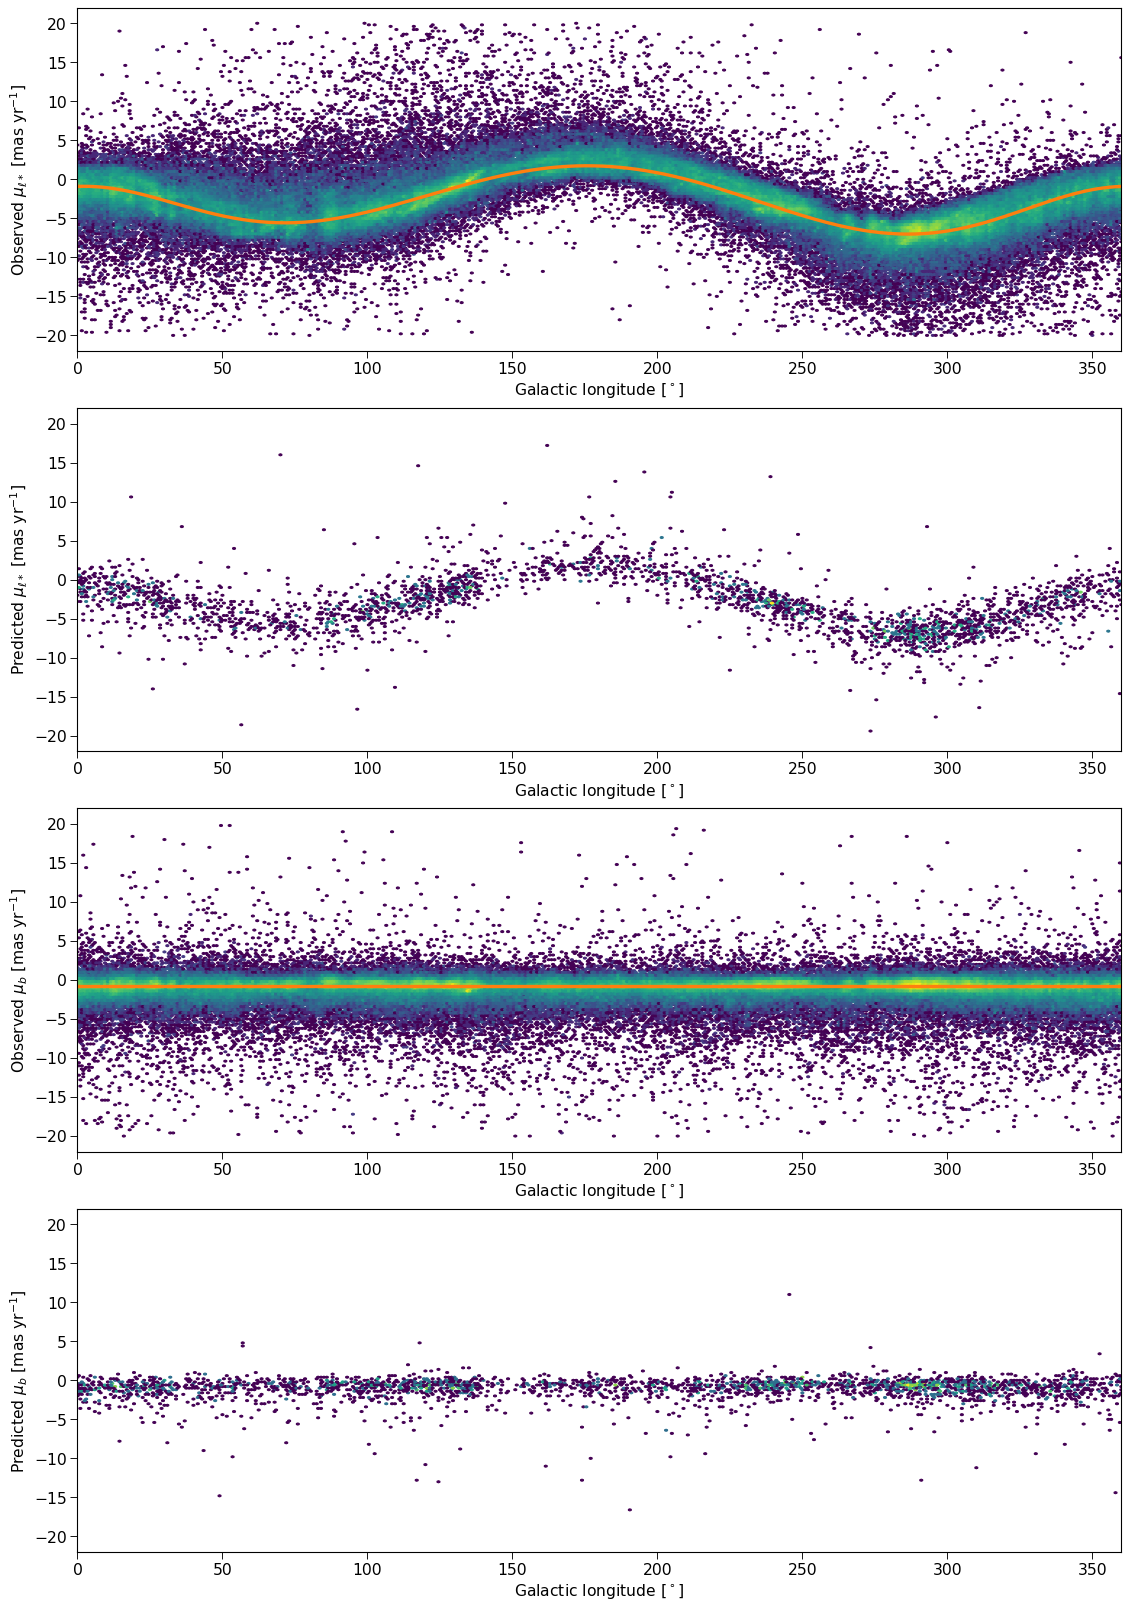

In [18]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1.0/np.median(obatable['parallax'][sample_filter])
print(median_dist)

#pml_model, pmb_model, vrad_model = diskmodel_flat.observables(1000.0/obatable['parallax'][sample_filter].value*u.pc, 
#                                                              obatable['l'][sample_filter]*u.deg, obatable['b'][sample_filter]*u.deg)

mcsample = np.random.choice(posterior_predictive_samples.shape[0])

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmul_model = fig.add_subplot(gs[1,0])
#im_lmul_model = ax_lmul_model.hexbin(obatable['l'][sample_filter], pml_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmul_model = ax_lmul_model.hexbin(oba_subsample['l'], posterior_predictive_samples[mcsample, :, 0], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

ax_lmub_model = fig.add_subplot(gs[3,0])
#im_lmub_model = ax_lmub_model.hexbin(obatable['l'][sample_filter], pmb_model, 
#                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
im_lmub_model = ax_lmub_model.hexbin(oba_subsample['l'], posterior_predictive_samples[mcsample, :, 1], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.kpc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)

plt.show()

## Overplot model predictions for specific distances on observed proper motions

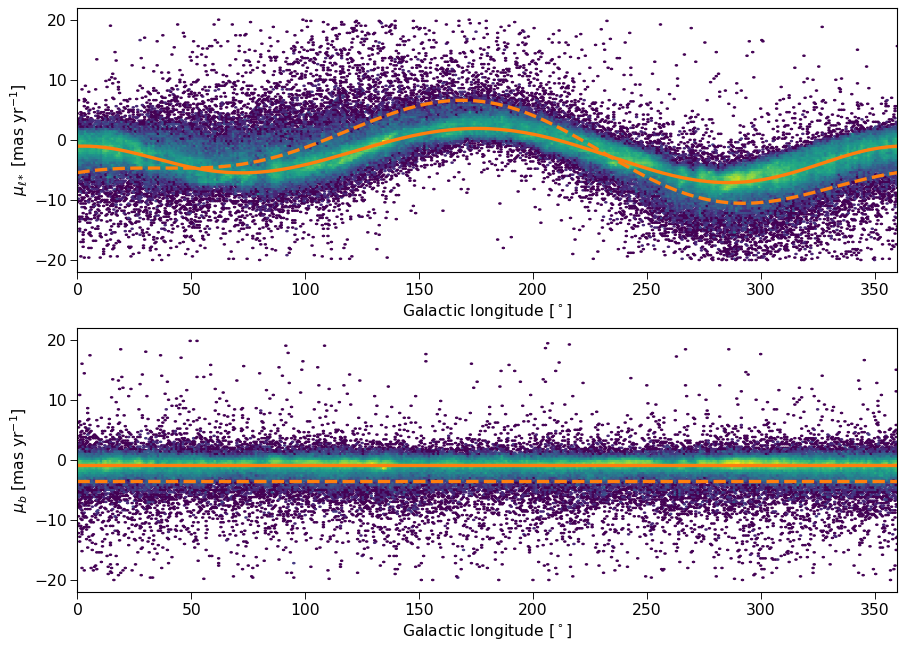

In [19]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

for dist, lstyle in zip([0.5, 2.0], ['--C1', '-C1']):
    distance = np.zeros_like(galon.value) + dist*u.kpc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, lstyle, lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, lstyle, lw=3)

plt.savefig('bstar-pml-pmb-vs-galon-plusmodel.png')

plt.show()